# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score,  r2_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.model_selection import KFold


%matplotlib inline

# Download & Load Data

Data:

* https://github.com/gastonstat/CreditScoring
* Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-03 22:55:59--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: 'CreditScoring.csv.2'

     0K .......... .......... .......... .......... .......... 28%  892K 0s
    50K .......... .......... .......... .......... .......... 56%  264K 0s
   100K .......... .......... .......... .......... .......... 84%  194K 0s
   150K .......... .......... ........                        100%  284K=0,6s

2021-10-03 22:56:00 (295 KB/s) - 'CreditScoring.csv.2' saved [182489/182489]



## Preparation
We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

In [4]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Some of the features are encoded as numbers. Use the following code to de-code them:

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)


Prepare the numerical variables:

In [6]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [7]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [8]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

# Your code
What are the categorical variables? What are the numerical?

In [9]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4454 entries, 0 to 4453
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   seniority  4454 non-null   int64 
 1   home       4454 non-null   object
 2   time       4454 non-null   int64 
 3   age        4454 non-null   int64 
 4   marital    4454 non-null   object
 5   records    4454 non-null   object
 6   job        4454 non-null   object
 7   expenses   4454 non-null   int64 
 8   income     4454 non-null   int64 
 9   assets     4454 non-null   int64 
 10  debt       4454 non-null   int64 
 11  amount     4454 non-null   int64 
 12  price      4454 non-null   int64 
 13  default    4454 non-null   int32 
dtypes: int32(1), int64(9), object(4)
memory usage: 469.9+ KB


,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [10]:
# Categorical Features
categorical = list(df.dtypes[df.dtypes == 'object'].index)

In [11]:
categorical

['home', 'marital', 'records', 'job']

In [12]:
numerical = df.select_dtypes(exclude=['object']).columns.tolist()
numerical

['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price',
 'default']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

# Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenses'])


AUC can go below 0.5 if the variable is negatively correlated with the target varialble. 

You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [15]:
numerical = ['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price']

categorical = ['home', 'marital', 'records', 'job']

Which numerical variable (among the following 4) has the highest AUC?

* seniority
* time
* income
* debt

In [16]:
d_auc_roc = {}
for variable in numerical:
    fpr, tpr, thresholds = roc_curve(y_train, df_train[variable].values)
    auc_score = auc(fpr, tpr)
    
    if auc_score < 0.5:
        fpr, tpr, thresholds = roc_curve(y_train, -df_train[variable].values)
        auc_score = auc(fpr, tpr)
    d_auc_roc[variable] = auc_score    
    
    print(f'{variable} -- feature has a auc score of: {auc_score}')

seniority -- feature has a auc score of: 0.705547271410607
time -- feature has a auc score of: 0.5615415808350418
age -- feature has a auc score of: 0.5697789703140826
expenses -- feature has a auc score of: 0.5015186692958463
income -- feature has a auc score of: 0.674563481966796
assets -- feature has a auc score of: 0.6448650262020912
debt -- feature has a auc score of: 0.5051067778033301
amount -- feature has a auc score of: 0.5944773771486449
price -- feature has a auc score of: 0.5045483625527835


In [17]:
print(d_auc_roc)
print('')
sorted(d_auc_roc.items(), key=lambda x: x[1], reverse=True)


{'seniority': 0.705547271410607, 'time': 0.5615415808350418, 'age': 0.5697789703140826, 'expenses': 0.5015186692958463, 'income': 0.674563481966796, 'assets': 0.6448650262020912, 'debt': 0.5051067778033301, 'amount': 0.5944773771486449, 'price': 0.5045483625527835}



[('seniority', 0.705547271410607),
 ('income', 0.674563481966796),
 ('assets', 0.6448650262020912),
 ('amount', 0.5944773771486449),
 ('age', 0.5697789703140826),
 ('time', 0.5615415808350418),
 ('debt', 0.5051067778033301),
 ('price', 0.5045483625527835),
 ('expenses', 0.5015186692958463)]

# Answer 1: Seniority with auc_roc = 0.7055

## Training the model
From now on, use these columns only:

    ['seniority', 'income', 'assets', 'records', 'job', 'home']

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

    LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [18]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']

dv = DictVectorizer(sparse=False)
train_dict = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[features].to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

In [19]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

# Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.512
* 0.612
* 0.712
* 0.812

In [20]:
y_pred = model.predict_proba(X_val)[:,1]


In [21]:
roc_auc_score(y_val, y_pred)
print("AUC of this model on the validation dataset : %s" % round(roc_auc_score(y_val, y_pred), 3))

AUC of this model on the validation dataset : 0.826


# Answer 2 : 0.826

# Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [22]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    scores.append((t, tp, fp, fn, tn, precision, recall))

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


In [23]:
col_features = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=col_features)
df_scores.head()

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,195,518,0,0,0.273492,1.000000
1,0.01,195,511,0,7,0.276204,1.000000
2,0.02,193,500,2,18,0.278499,0.989744
3,0.03,192,483,3,35,0.284444,0.984615
4,0.04,192,462,3,56,0.293578,0.984615


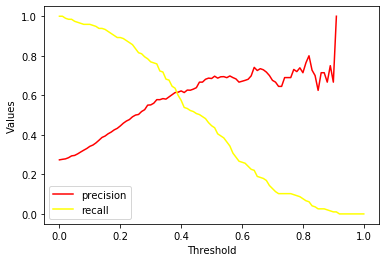

In [24]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision', color='red')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall', color='yellow')
plt.legend()

plt.xlabel('Threshold')
plt.ylabel('Values')
plt.show()

C:\Users\hp\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


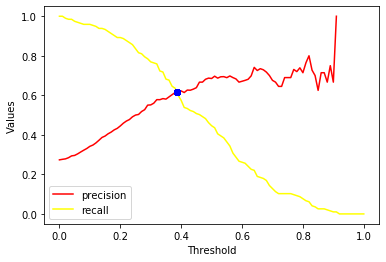

In [25]:
idx=np.argwhere(np.diff(np.sign(df_scores['precision'] - df_scores['recall'] )) != 0).reshape(-1) + 0

plt.plot(df_scores.threshold, df_scores['precision'], label='precision', color='red')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall', color='yellow')
plt.xlabel('Threshold')
plt.ylabel('Values')
for i in range(len(idx)):
    plt.plot((df_scores.threshold[idx[0]]+df_scores.threshold[idx[0]+1])/2.,(df_scores['precision'][idx[0]]+df_scores['precision'][idx[0]+1])/2., 'bo')

plt.legend()
plt.show()   

C:\Users\hp\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


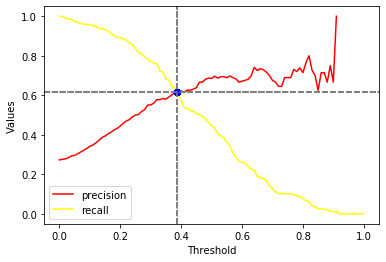

In [26]:
idx=np.argwhere(np.diff(np.sign(df_scores['precision'] - df_scores['recall'] )) != 0).reshape(-1) + 0

plt.plot(df_scores.threshold, df_scores['precision'], label='precision', color='red')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall', color='yellow')
plt.xlabel('Threshold')
plt.ylabel('Values')
for i in range(len(idx)):
    plt.plot((df_scores.threshold[idx[0]]+df_scores.threshold[idx[0]+1])/2.,(df_scores['precision'][idx[0]]+df_scores['precision'][idx[0]+1])/2.,'bo')
    plt.axvline(x=(df_scores.threshold[idx[0]]+df_scores.threshold[idx[0]+1])/2.,color='gray',linestyle='--')
    plt.axhline(y=(df_scores['precision'][idx[0]]+df_scores['precision'][idx[0]+1])/2.,color='gray',linestyle='--')
    
plt.legend()
plt.show()   

# Answer 3: the intersection point of the 2 plot is **0.4**

# Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$
Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [27]:
df_scores['F1'] = (2*df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall'])
df_scores.head()

,threshold,tp,fp,fn,tn,precision,recall,F1
0,0.00,195,518,0,0,0.273492,1.000000,0.429515
1,0.01,195,511,0,7,0.276204,1.000000,0.432852
2,0.02,193,500,2,18,0.278499,0.989744,0.434685
3,0.03,192,483,3,35,0.284444,0.984615,0.441379
4,0.04,192,462,3,56,0.293578,0.984615,0.452297


At which threshold F1 is maximal?

* 0.1
* 0.3
* 0.5
* 0.7

In [28]:
round(df_scores[df_scores['F1'] == df_scores.F1.max()],2)

,threshold,tp,fp,fn,tn,precision,recall,F1
32,0.32,148,108,47,410,0.58,0.76,0.66


# Answer 4 : F1 is maximal at 0.66 which is about 0.7

# Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

* KFold(n_splits=5, shuffle=True, random_state=1)
* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

In [29]:
# let's create a function  to train and another to predict 

def train(df_train, y_train, c=1.0):
    dicts = df_train.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')
    
    X = dv.transform(dicts)    
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [30]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [31]:
kfold

KFold(n_splits=5, random_state=1, shuffle=True)

In [32]:
kf_scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    
    # get the train and val data from the 5 kfolds
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    # get y_train, y_val
    y_train = df_train.default.values
    y_val = df_val.default.values
    
    # train the model
    dv, model = train(df_train[features], y_train)
    # predict
    y_pred = predict(df_val[features], dv, model)
    # score using roc_auc score
    auc = roc_auc_score(y_val, y_pred)
    kf_scores.append(auc)

How large is standard devidation of the scores across different folds?

* 0.001
* 0.014
* 0.09
* 0.14

In [33]:
print(f'{np.mean(kf_scores):.4f} +- {np.std(kf_scores):.4f}')

0.8142 +- 0.0146


# Answer 5: standard devidation is 0.0146 large.

# Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.01, 0.1, 1, 10]
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [34]:
n_splits = 5

for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train[features], y_train, c=C)
        y_pred = predict(df_val[features], dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C= {0}, mean_5folds_score = {1} +- std_5folds_score= {2}'.format(C, round(np.mean(scores),3), round(np.std(scores),3)))

C= 0.01, mean_5folds_score = 0.808 +- std_5folds_score= 0.012
C= 0.1, mean_5folds_score = 0.813 +- std_5folds_score= 0.014
C= 1, mean_5folds_score = 0.814 +- std_5folds_score= 0.015
C= 10, mean_5folds_score = 0.814 +- std_5folds_score= 0.015


Which C leads to the best mean score?

* 0.01
* 0.1
* 1
* 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

# Answer 6 : the best C is:

* C= 1,  mean_5folds_score = 0.814 +- std_5folds_score= 0.015
* C= 10, mean_5folds_score = 0.814 +- std_5folds_score= 0.015

They both have same mean and same std so will chose the smallest so **C=1**
